In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Network architecture:


**Goal**: the predict the x-y co-ordinates of the top and bottom layer hits from the calorimeter images, the total deposited energy, and the maxEbar energy. 

Since we are dealing with images, the natural choice is to train a CNN. As a first pass, let us train a simple CNN with the images and the energy deposits

Let's load the preprocessed data

In [2]:
unzip_data = np.load("data/train_data.npz")
calorimeter_images = unzip_data['arr_0']
calorimeter_energies = unzip_data['arr_1']
sum_pixels_layer = unzip_data['arr_2']
data_target = unzip_data['arr_3']

In [3]:
N_CHANNELS = 22
N_LAYERS = 14
N_X_LAYERS = 7
N_Y_LAYERS = 7

As a sanity check, let's plot a couple of images

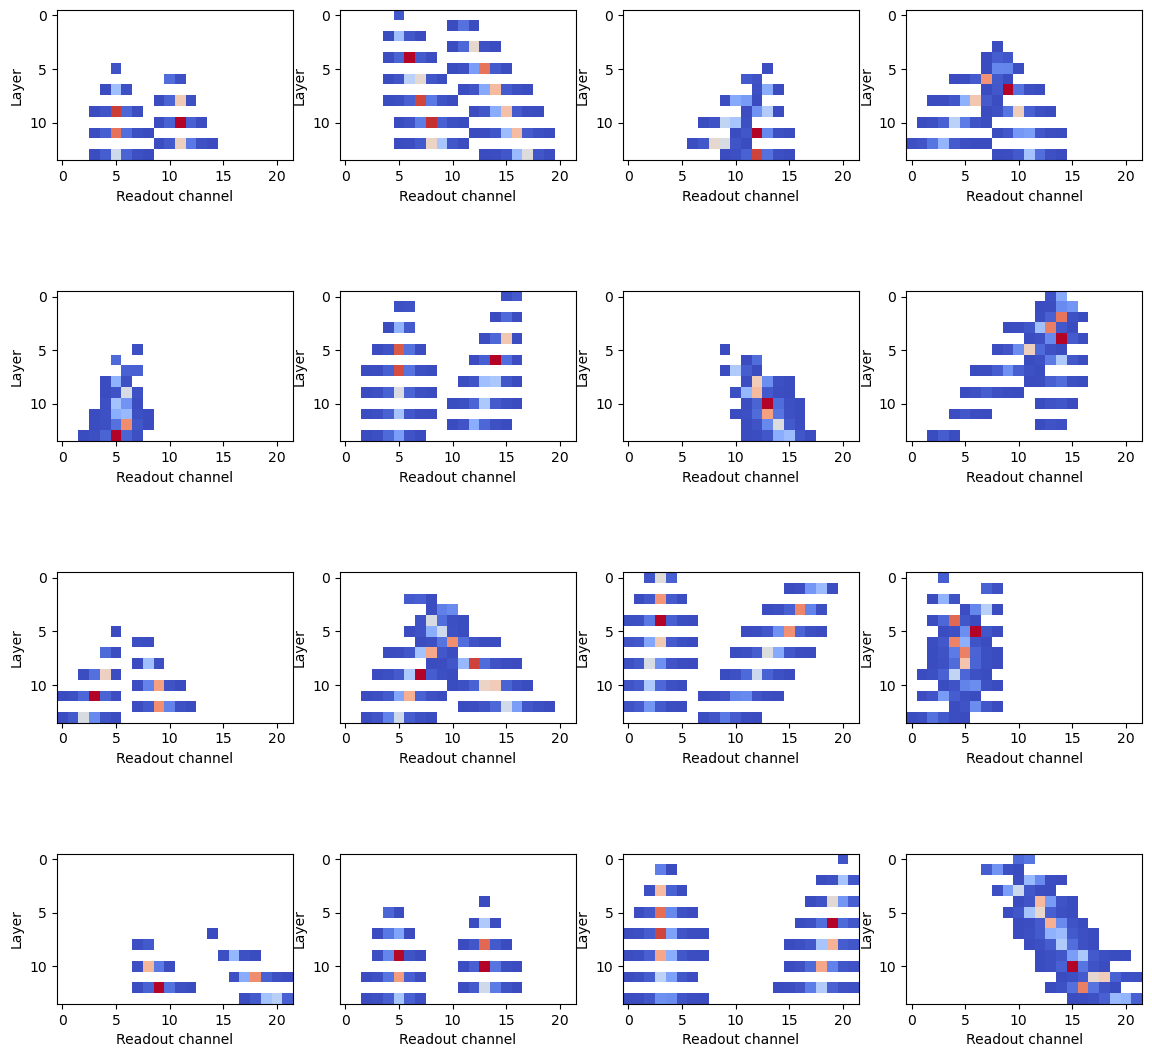

In [4]:
n_c = 4
n_r = 4
fig, ax = plt.subplots(n_c, n_r, figsize=(14, 14))
for i, ax in enumerate(fig.axes):
    # Here we make a copy so we can manipulate the array without changing it in calorimeter_images
    image = calorimeter_images[i].copy()
    # Filling the zero values with NaNs will show us white space where there is zero deposits recorded.
    # Note that if we didn't have the copy there, this would insert NaNs into calorimeter_images.
    image[image == 0] = 'nan'
    ax.imshow(image, cmap="coolwarm")
    ax.set_xlabel("Readout channel")
    ax.set_ylabel("Layer")
plt.show()

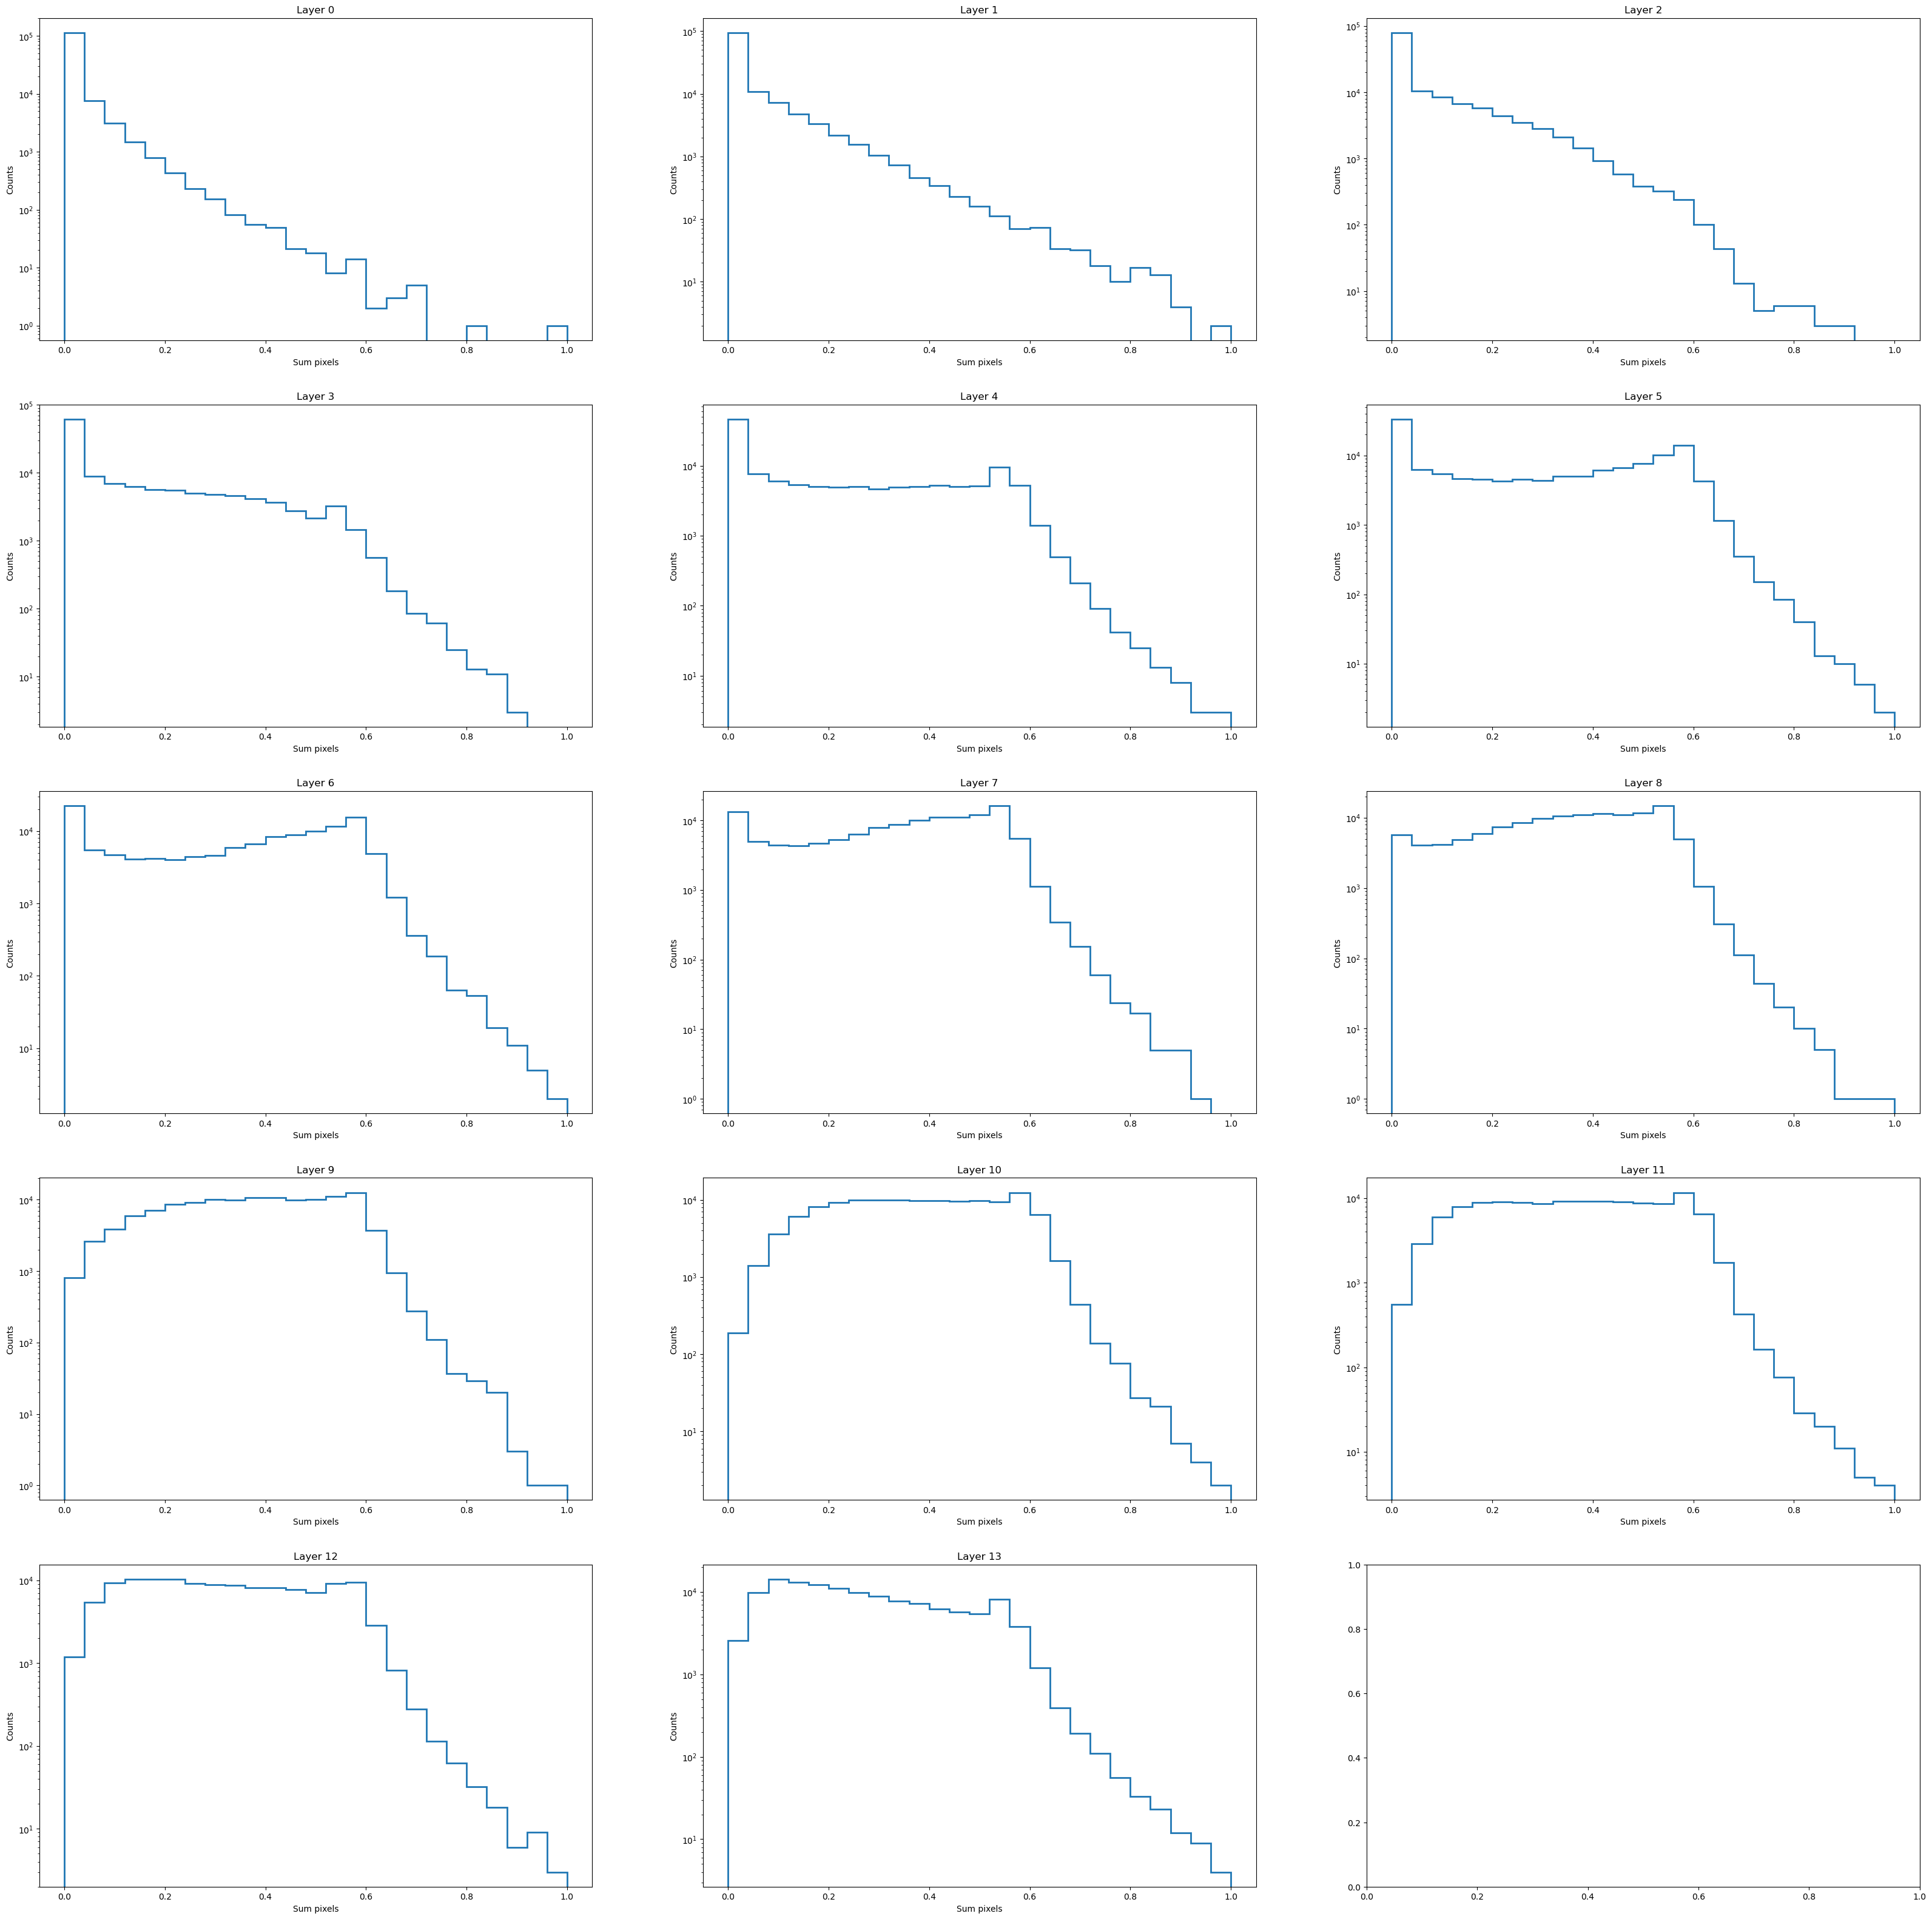

In [5]:
fig, _ = plt.subplots(5,3, figsize=(40,40))
axes = fig.axes

for i_layer in range(N_LAYERS):
    axes[i_layer].hist(sum_pixels_layer[:,i_layer], bins=np.linspace(0,1,26), histtype='step', linewidth=2)
    axes[i_layer].set_title(f"Layer {i_layer}")
    axes[i_layer].set_xlabel("Sum pixels")
    axes[i_layer].set_ylabel("Counts")
    axes[i_layer].semilogy()

plt.show()
fig.clf()

## Split the data into training and testing datasets

In [6]:
from sklearn.model_selection import train_test_split

In [11]:
train_images, test_images, \
train_energies, test_energies, \
train_sume_pixels, test_sume_pixels, \
train_coords, test_coords \
= train_test_split(calorimeter_images, 
                   calorimeter_energies, 
                   sum_pixels_layer, 
                   data_target, 
                   test_size=0.3, shuffle=True)

In [12]:
train_enrgies = train_energies #np.concatenate((train_energies, train_sume_pixels), axis=1)
test_enrgies  = test_energies #np.concatenate((test_energies, test_sume_pixels), axis=1)

In [13]:
calorimeter_energies.shape

(127751, 2)

In [14]:
train_images.shape

(89425, 14, 22, 1)

In [15]:
train_x_images = train_images[:,0:14:2,:,:]
train_y_images = train_images[:,1:15:2,:,:]

In [16]:
test_x_images = test_images[:,0:14:2,:,:]
test_y_images = test_images[:,1:15:2,:,:]

## Set up a network

First, let us set up a CNN with just the images

In [17]:
from tensorflow import keras
from keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, MaxPool2D
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model

In [18]:
N_ENERGIES = 2

In [ ]:
# network_arch = {
#                 "num_conv_layers"     : 3,
#                 "activation"          : "relu",
#                 "filters_per_layer"   : [32,64,64],
#                 "strides_per_layer"   : (1,1),
#                 "data_format"         : "channels_last",
#                 "use_bias"            : True,
#                 "use_pool"            : True,
#                 "alternate_pool_conv" : True,
#                 "pool_size"           : (2,2),
#                 "num_dense_layers"    : 1,
#                 "num_dense_units"     : 128,
#                 "num_dropout_layers"  : 1,
#                 "dropout_rate"        : 0.2
#                 }

In [ ]:
# import tensorflow
# class MyModel(tensorflow.keras.Model):
    
#     def __init__(self, arch_dict):
#         super(MyModel, self).__init__()
        
#         self.input_image_layer = Input(shape=(N_LAYERS, N_CHANNELS, 1))
#         self.input_energy_layer = Input(shape=(N_ENERGIES,))
#         self.layer = []
#         self.build_hidden_layer(arch_dict)
    
#     def build_hidden_layer(self, arch_dict):
        
#         activation_function = arch_dict["activation"]
#         use_bias = arch_dict["use_bias"]
#         data_format = arch_dict["data_format"]
#         num_conv_layer = arch_dict["num_conv_layers"]
        
#         for i_conv in range(num_conv_layer):
#             filters_per_layer = arch_dict["filters_per_layer"]
            
#             if not isinstance(filters_per_layer, list):
#                 filter_size = filters_per_layer
#             else:
#                 filter_size = filters_per_layer[i_conv]
            
#             self.layer.append( Conv2D( activation=activation_function,
#                                         use_bias=use_bias,
#                                         data_format=data_format,
#                                         filters=filter_size,
#                                         kernel_size=(3,3),
#                                         strides=arch_dict["strides_per_layer"],
#                                         padding="same"
#                                        ) )
            
#             if arch_dict["alternate_pool_conv"] and i_conv < num_conv_layer-1:
#                 self.layer.append( MaxPool2D( pool_size=arch_dict["pool_size"],
#                                                data_format=data_format) )
            
#         # Add the global max pooling layer
#         self.layer.append( GlobalMaxPooling2D() )
        
#         # Add the energy input layer
#         self.layer.append( Concatenate(axis=-1) )
        
#         # Add a flatten layer
#         self.layer.append( Flatten() )
        
#         # Add the dense layer
#         for i_dense in range(arch_dict["num_dense_layers"]):
#             self.layer.append( Dense( units=arch_dict["num_dense_units"],
#                                        activation=activation_function,
#                                        use_bias=use_bias) )
        
#         # Add the dropout layer
#         for i_drop in range(arch_dict["num_dropout_layers"]):
#             self.layer.append( Dropout( arch_dict["dropout_rate"] ) )
        
#         # Add the output layer
#         self.layer.append( Dense(units=4, activation="linear") )
        
    
#     def call(self, inputs):
#         input_images, input_energies = inputs
        
#         self.layer[0](self.input_image_layer)
#         x = self.layer[0]
#         for layer in self.layer[1:]:
#             if isinstance(layer, Concatenate):
#                 x = layer([x, self.input_energy_layer])
#             else:
#                 x = layer(x)
#         return x
    

In [19]:
in_x_images = Input(shape=(N_X_LAYERS, N_CHANNELS, 1))
in_y_images = Input(shape=(N_Y_LAYERS, N_CHANNELS, 1))
in_energies = Input(shape=(N_ENERGIES,))

h_in_x = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,
            activation="relu")(in_x_images)

h_x = MaxPool2D(pool_size=(2,2),
              data_format="channels_last")(h_in_x)

h_x = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,
            activation='relu')(h_x)

h_x = MaxPool2D(pool_size=(2,2),
              data_format="channels_last")(h_x)

h_x = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,           
            activation='relu')(h_x)

h_in_y = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,
            activation="relu")(in_y_images)

h_y = MaxPool2D(pool_size=(2,2),
              data_format="channels_last")(h_in_y)

h_y = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,
            activation='relu')(h_y)

h_y = MaxPool2D(pool_size=(2,2),
              data_format="channels_last")(h_y)

h_y = Conv2D(filters=32,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            data_format="channels_last",
            use_bias=True,           
            activation='relu')(h_y)

h_image = Concatenate(axis=-1)([h_x, h_y])

h = GlobalMaxPooling2D()(h_image)

h = Concatenate(axis=-1)([h, in_energies])

h = Flatten()(h)

h = Dense(units=64, activation='relu', use_bias=True)(h)

h = Dropout(0.2)(h)

outputs = Dense(units=4, activation='linear')(h)

model = Model(inputs=[in_x_images, in_y_images, in_energies], outputs=outputs)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 22, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7, 22, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 22, 32) │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 22, 32) │        320 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 3, 11, 32) │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 11, 32) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 3, 11, 32) │      9,248 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 3, 11, 32) │      9,248 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 5, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 5, 32)  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 5, 32)  │      9,248 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 5, 32)  │      9,248 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 5, 64)  │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ concatenate[0][0] │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 66)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 66)        │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,288 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout[0][0]   

 Total params: 42,180 (164.77 KB)

 Trainable params: 42,180 (164.77 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
batchsize = 128
learning_rate = 0.01
num_epochs = 500
verbosity = 1
early_stopping_patience = int(0.1*num_epochs)

In [22]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

In [23]:
model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

In [24]:
history = model.fit([train_x_images, train_y_images, train_energies], train_coords, 
                    epochs=num_epochs, verbose=verbosity,
                    batch_size=batchsize, validation_data=([test_x_images, test_y_images, test_energies], test_coords),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                               patience=early_stopping_patience,
                                                               restore_best_weights=True))

Epoch 1/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2053 - val_mean_squared_error: 0.2053
Epoch 2/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1651 - mean_squared_error: 0.1651 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Epoch 3/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 4/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 5/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 6/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 7/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - 

## Preliminary cross checks

In [25]:
import plotting

/Users/devanshu/UniGe/dampe-cnn/plotting.py:158: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.85, 0.8, f"$\mu$ = {popt[1]:0.3f}",
/Users/devanshu/UniGe/dampe-cnn/plotting.py:161: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.85, 0.75, f"$\sigma$ = {popt[2]:0.3f}",


In [26]:
plotting.make_pretty_format()

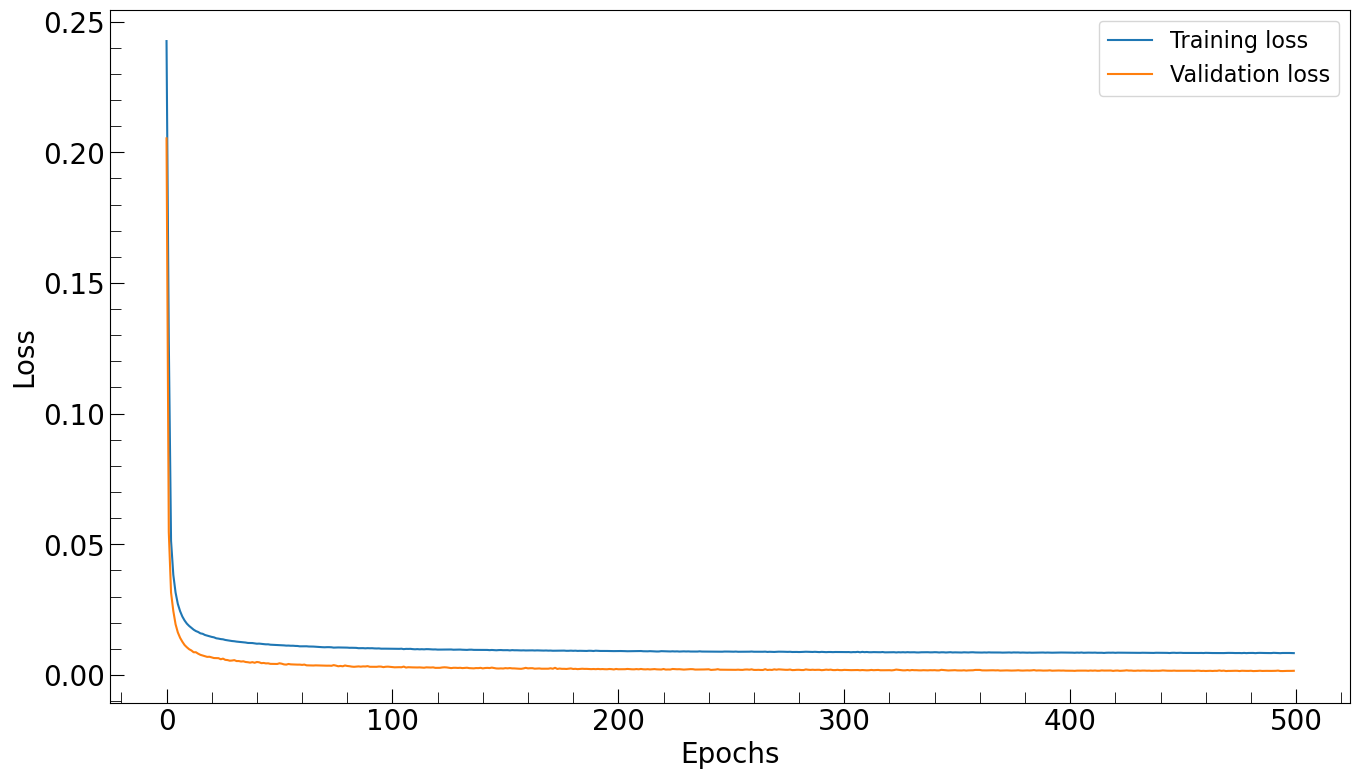

In [27]:
fig = plotting.plot_losses(history)

plt.minorticks_on()
# plt.semilogy()

plt.show()
# fig.savefig("cnn_2022_05_26_dropout_max_deposit_maxEbar_energies_loss.pdf")
fig.clf()

### Predict the x-y co-ordinates for the test data

In [29]:
pred_coords = model.predict([test_x_images, test_y_images, test_enrgies], batch_size=500)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


### Plot the predicted-truth linearity

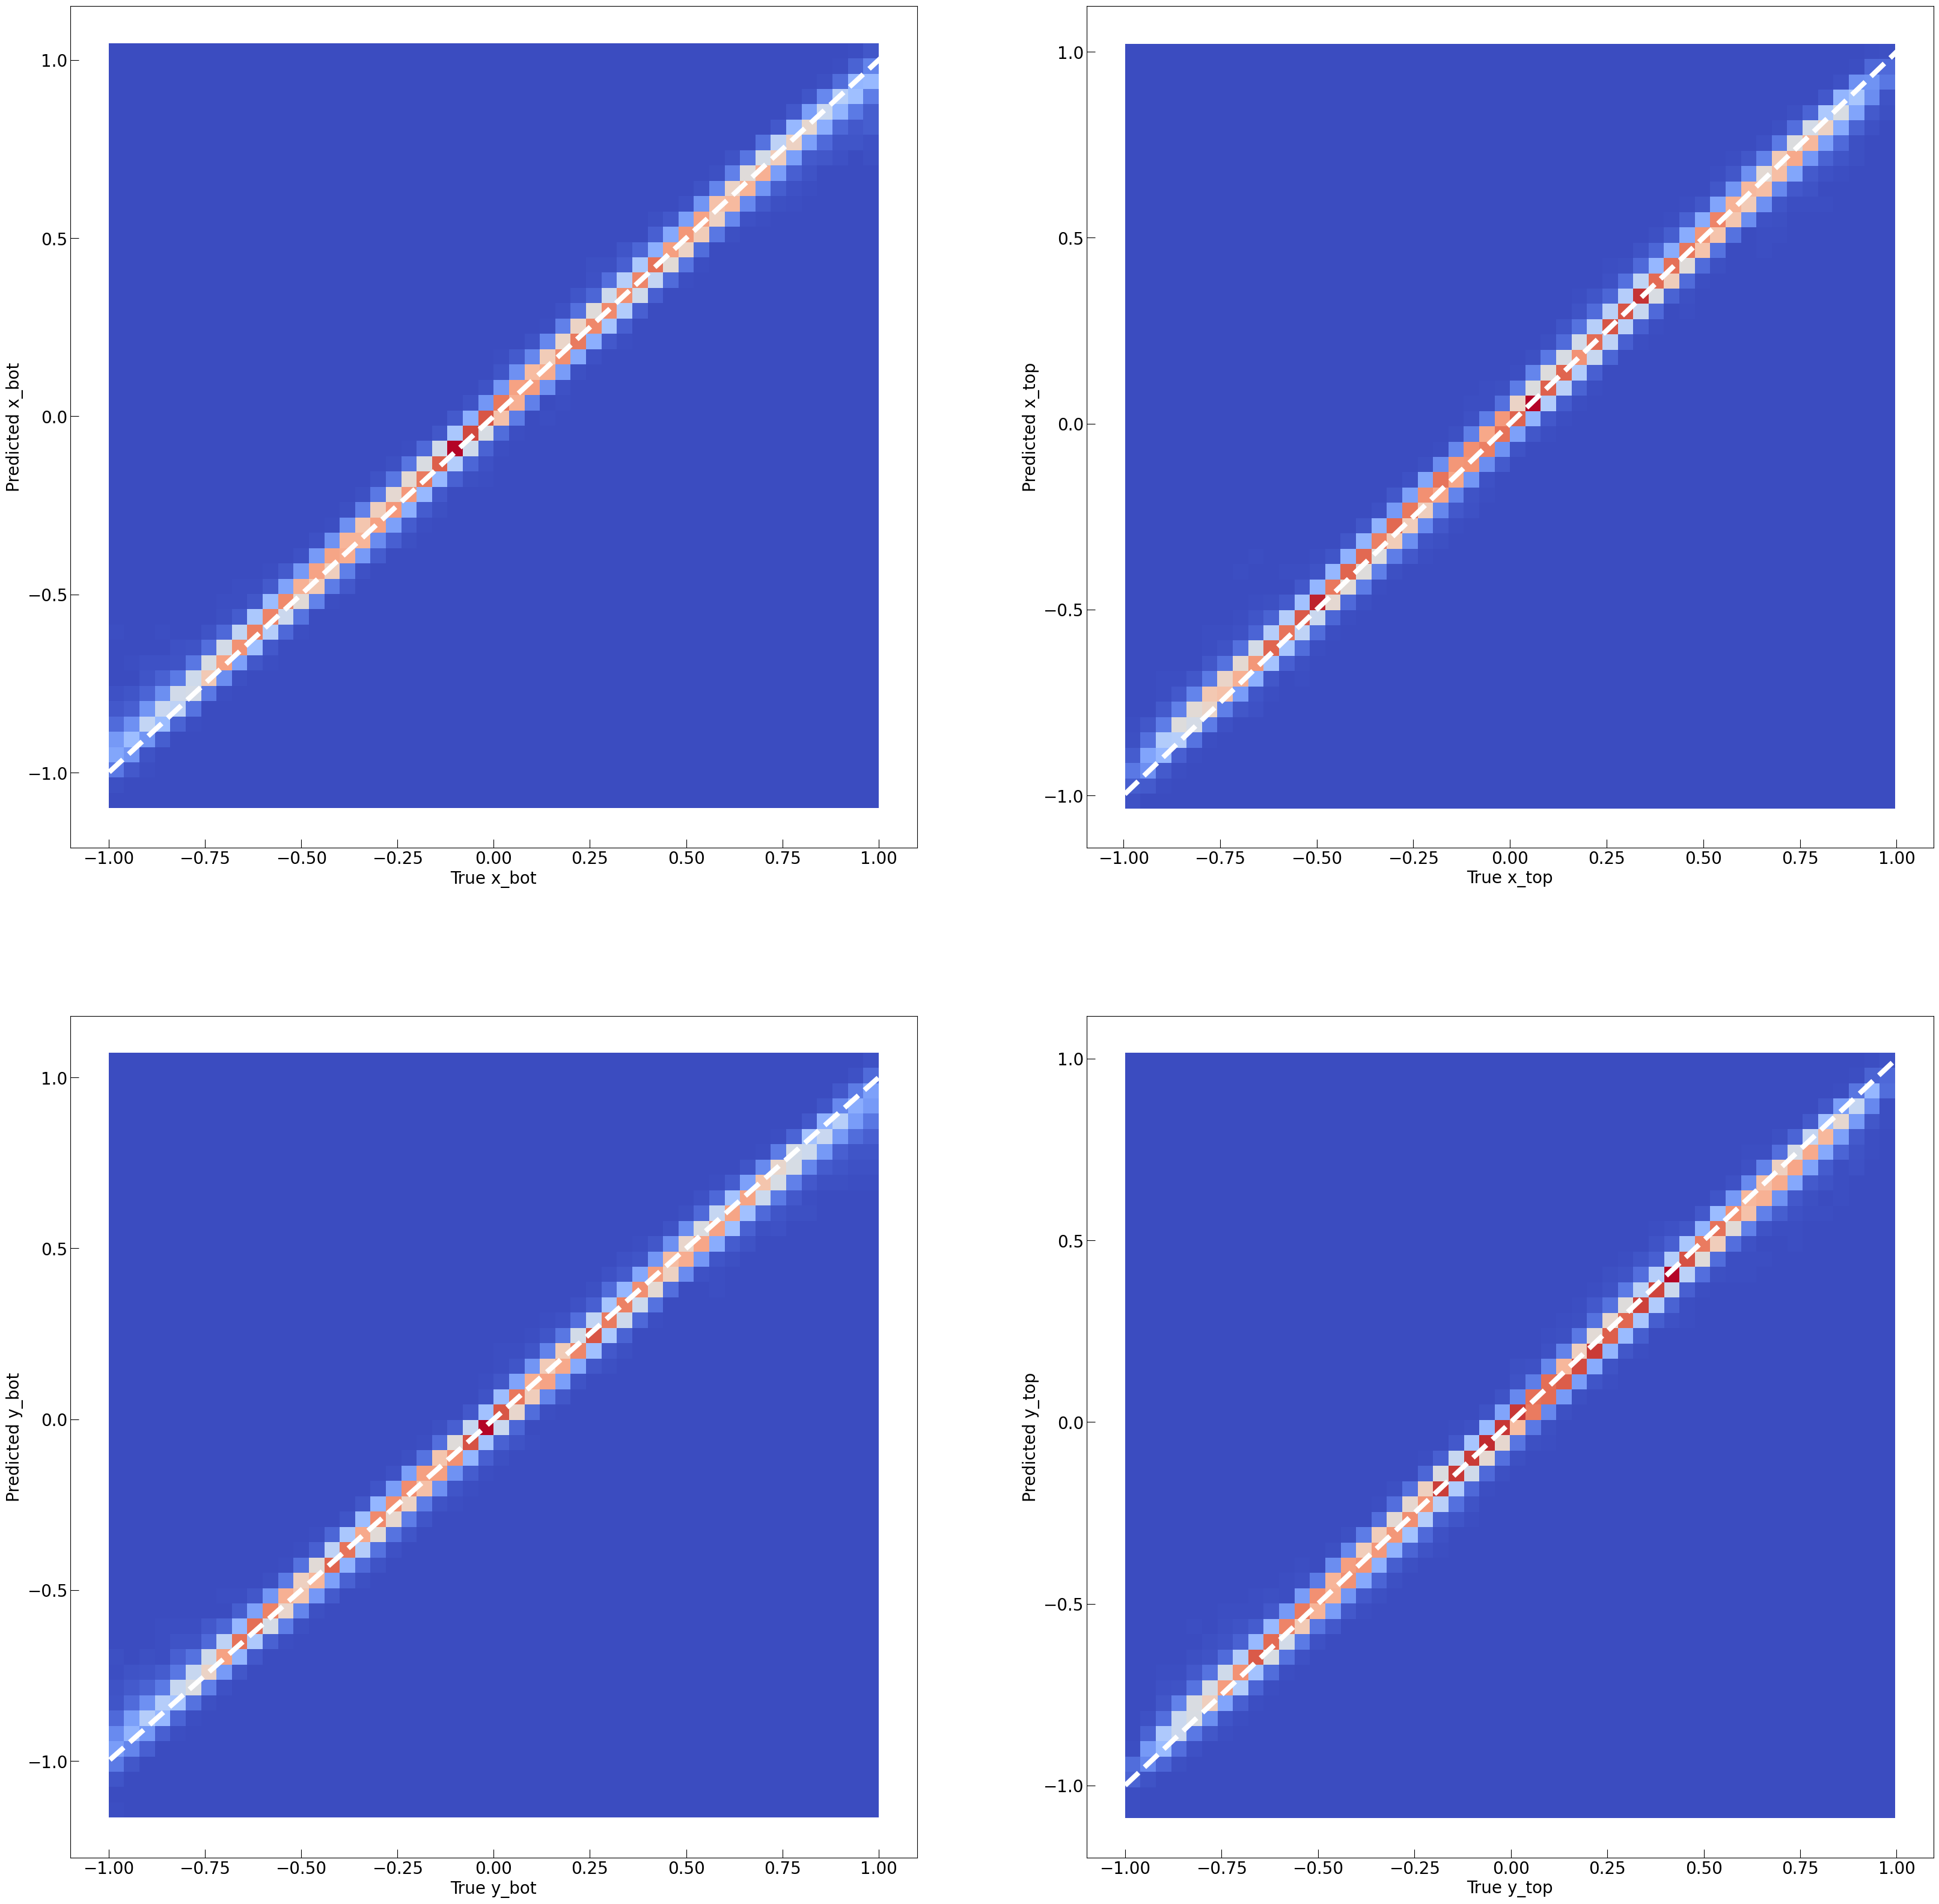

In [30]:
labels = ['x_bot', 'x_top', 'y_bot', 'y_top']

fig = plotting.plot_predictions(pred_coords, test_coords, var_label=labels)

# fig.savefig("cnn_2022_05_26_dropout_max_deposit_maxEbar_energies_linearity.pdf")
plt.show()
fig.clf()

### Plot the predicted - truth bias

In [31]:
def gaus_fit(x, A, mu, sigma):
    return (A / np.sqrt(sigma)) * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))

def plot_bias(prediction, truth, var_label='x_top', fit_bias=True):
    """
    Plot the bias and fit a gaussian distribution
    
    Inputs:
    prediction: (ndarray) Network predictions for the co-ordinate(s)
    truth: (ndarray) Truth co-ordinate(s)
    var_label: (str) Name of the co-ordinate to be added alongside the bias label
    fit_bias: (bool) Fit the bias using a Gaussian distribution
    
    Outputs:
    Matplotlib figure object
    """
    try:
        from scipy.optimize import curve_fit
    except ImportError:
        print("Cannot load scipy module curve_fit, cannot perform fit")
        fit_bias = False

    assert prediction.shape == truth.shape, "Please provide equal-sized arrays"
    
    num_cols, num_rows = 1,1
    fig_size = (12,12)
    
    if len(prediction.shape) > 1:
        num_rows, num_cols = 2,2
        fig_size = (40,40)
    
    if len(prediction.shape) == 1:
        prediction = np.reshape(prediction, prediction.shape + (1,))
        truth = np.reshape(truth, truth.shape + (1,))
        var_label = [var_label]
    
    bias = prediction - truth
    
    fig, _ = plt.subplots(num_rows, num_cols, figsize=fig_size)
    
    for i_coord, ax in enumerate(fig.axes):
        n, bins, _ = ax.hist(bias[:,i_coord], bins=100, histtype="step", linewidth=2, label="Data")
        ax.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
        
        if fit_bias:
            bin_centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
            popt, pcov = curve_fit(gaus_fit, 
                                   xdata=bin_centers, ydata=n, 
                                   p0=[1000., 0., 0.5*(n.max() - n.min())], 
                                   absolute_sigma=False)

            x_values = np.linspace(bin_centers[0],bin_centers[-1], 1000)
            ax.plot(x_values, gaus_fit(x_values, *popt), color='tab:orange', linewidth=2, label="Fit")
            
            ax.text(0.85, 0.8, f"N = {np.sum(n)}",
                    fontsize=18,
                    transform=ax.transAxes)
            ax.text(0.85, 0.75, f"$\mu$ = {popt[1]:0.3f}", 
                     fontsize=18,
                     transform=ax.transAxes)
            ax.text(0.85, 0.70, f"$\sigma$ = {popt[2]:0.3f}", 
                     fontsize=18,
                     transform=ax.transAxes)
            
        y_min = 1e-2 if min(n) >= 0.0 else min(n)*1e-2
        y_max = max(n)*1e2
        ax.set_ylim(y_min, y_max)
        ax.set_xlim(min(bins)-1, max(bins)+1)
        ax.semilogy()
        
        ax.legend(fontsize=16)
        ax.set_xlabel(f"(Pred. - True) {var_label[i_coord]}", fontsize=16)
        ax.set_ylabel(f"Counts", fontsize=16)
        
    return fig

<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\s'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\s'
/var/folders/gd/ddv3zxnd0fx9cx3cw9zc9jbw0000gn/T/ipykernel_52997/2974692058.py:58: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.85, 0.75, f"$\mu$ = {popt[1]:0.3f}",
/var/folders/gd/ddv3zxnd0fx9cx3cw9zc9jbw0000gn/T/ipykernel_52997/2974692058.py:61: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.85, 0.70, f"$\sigma$ = {popt[2]:0.3f}",


/var/folders/gd/ddv3zxnd0fx9cx3cw9zc9jbw0000gn/T/ipykernel_52997/2974692058.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (A / np.sqrt(sigma)) * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2))


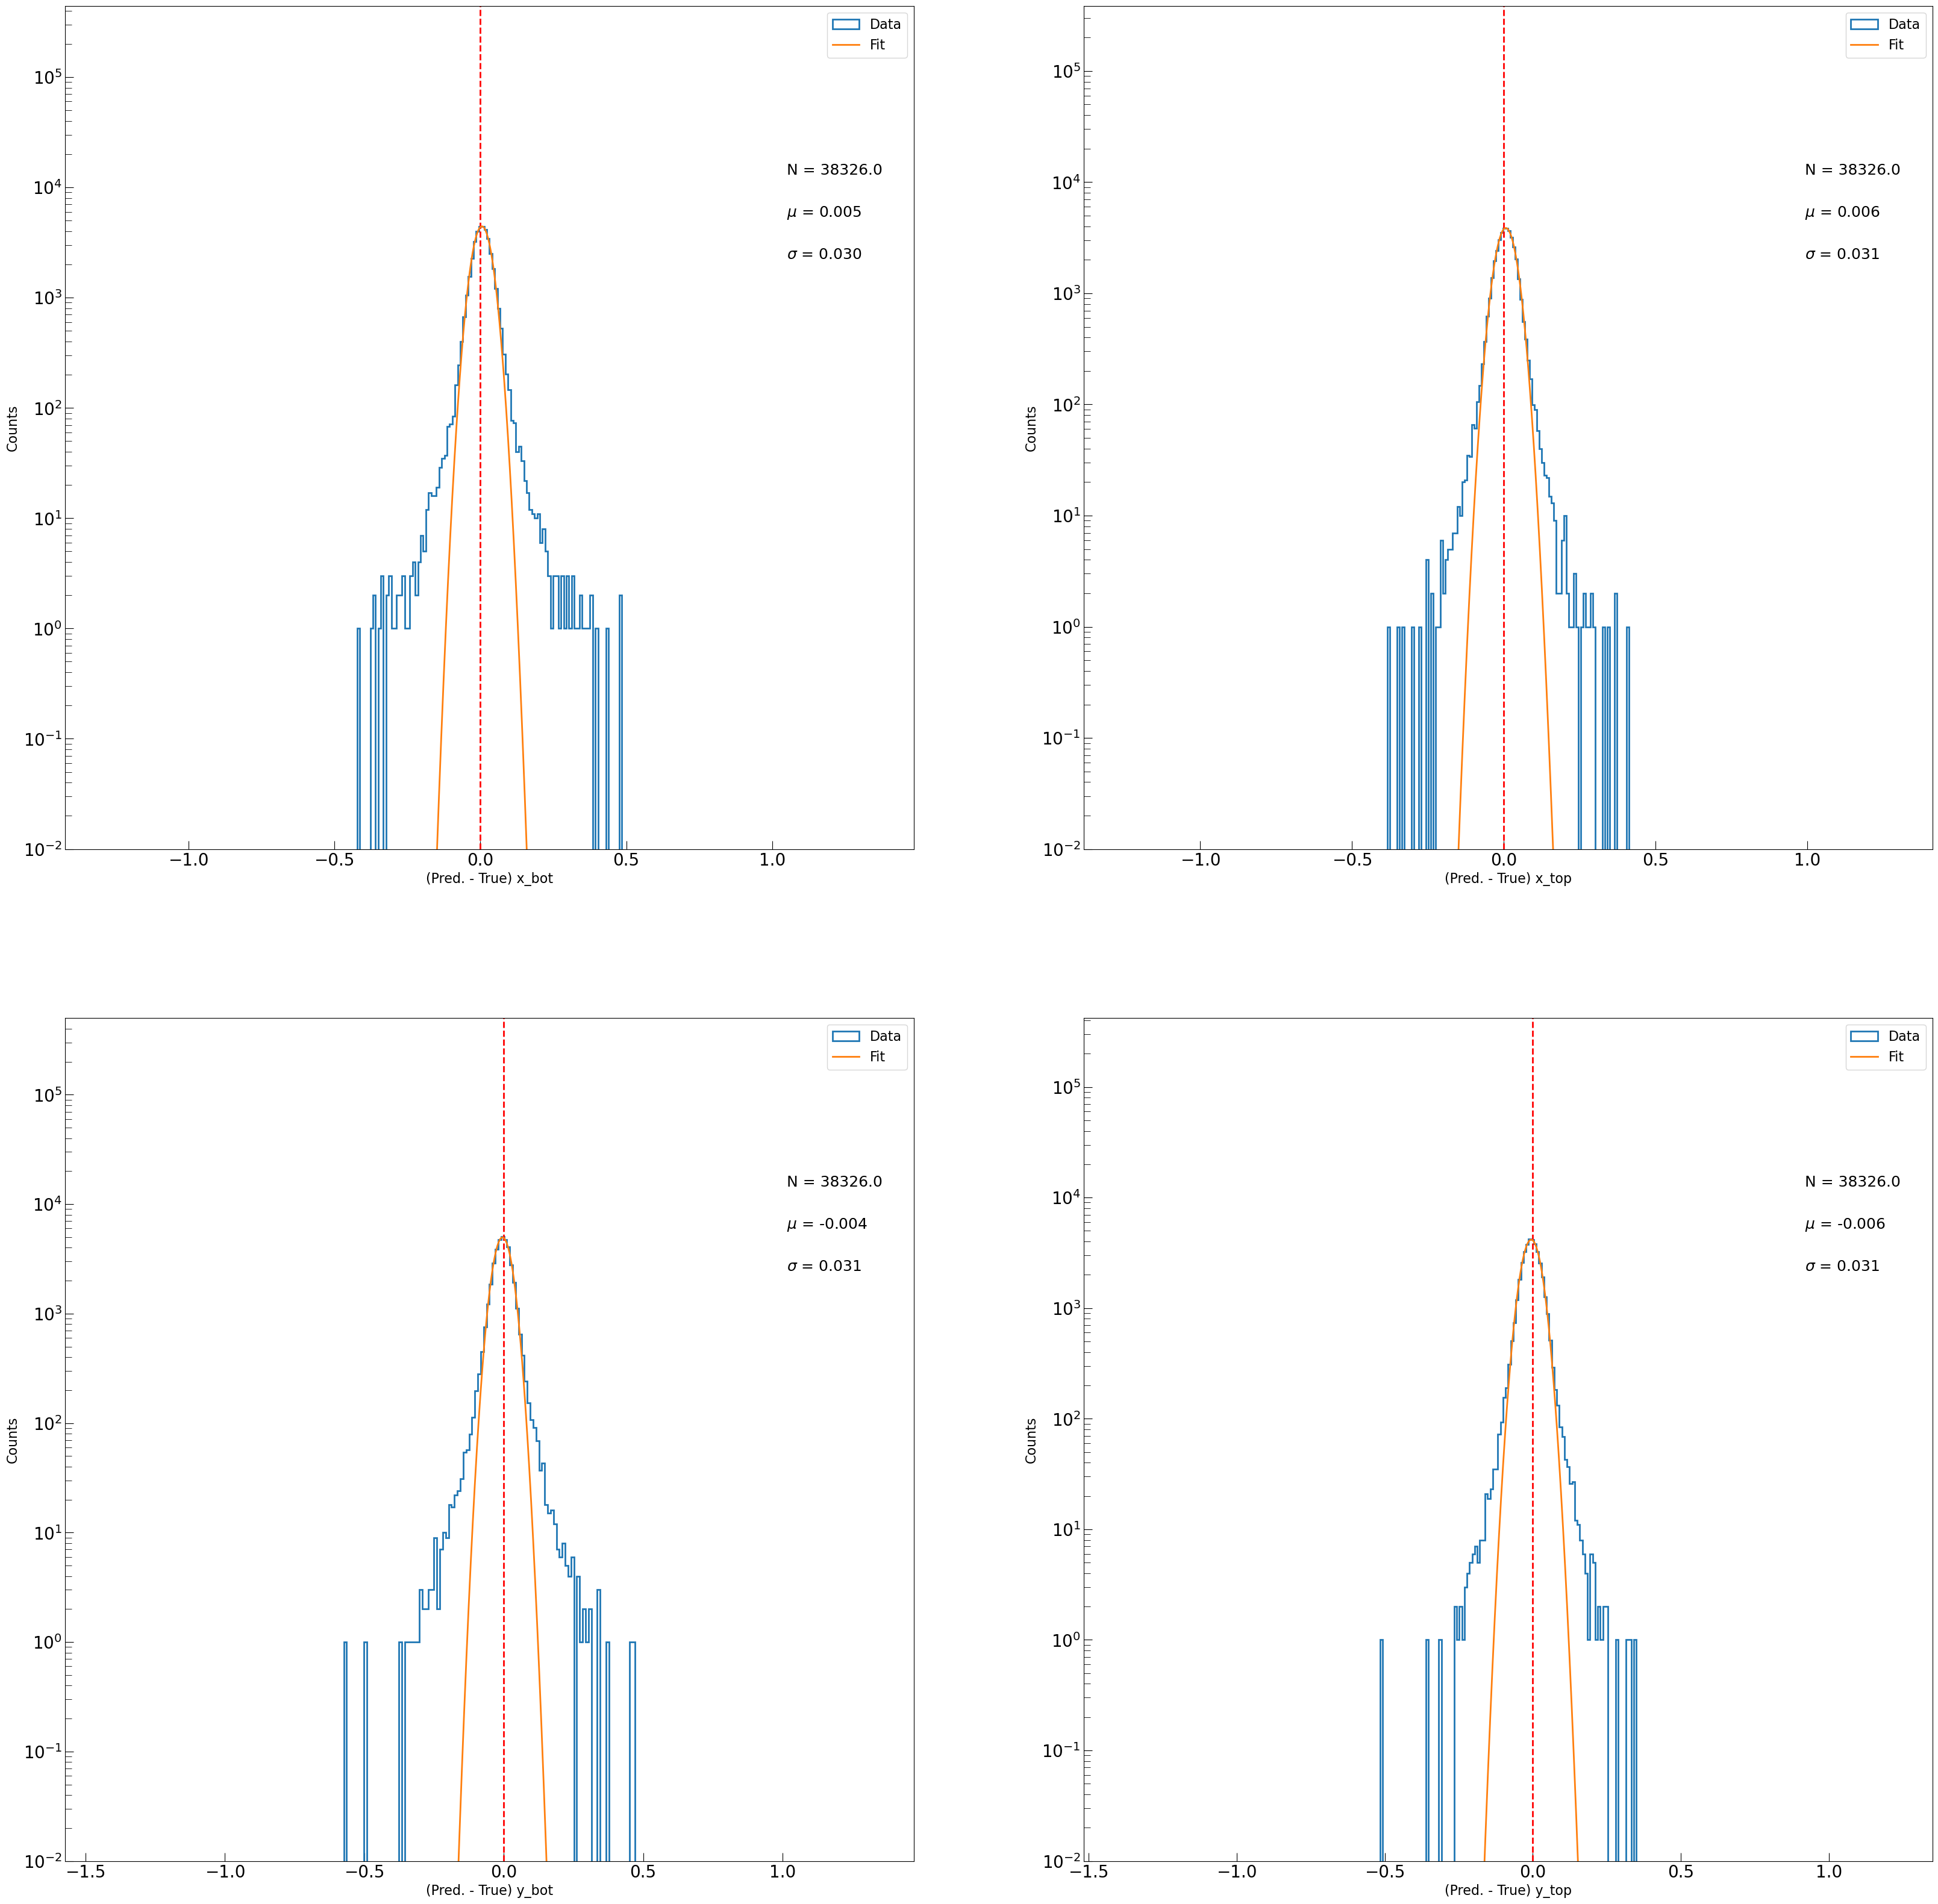

In [32]:
fig = plot_bias(pred_coords, test_coords, var_label=labels, fit_bias=True)

# fig.savefig("cnn_2022_05_26_dropout_max_deposit_maxEbar_energies_bias.pdf")
plt.show()
fig.clf()

### Plot the bias vs. truth 

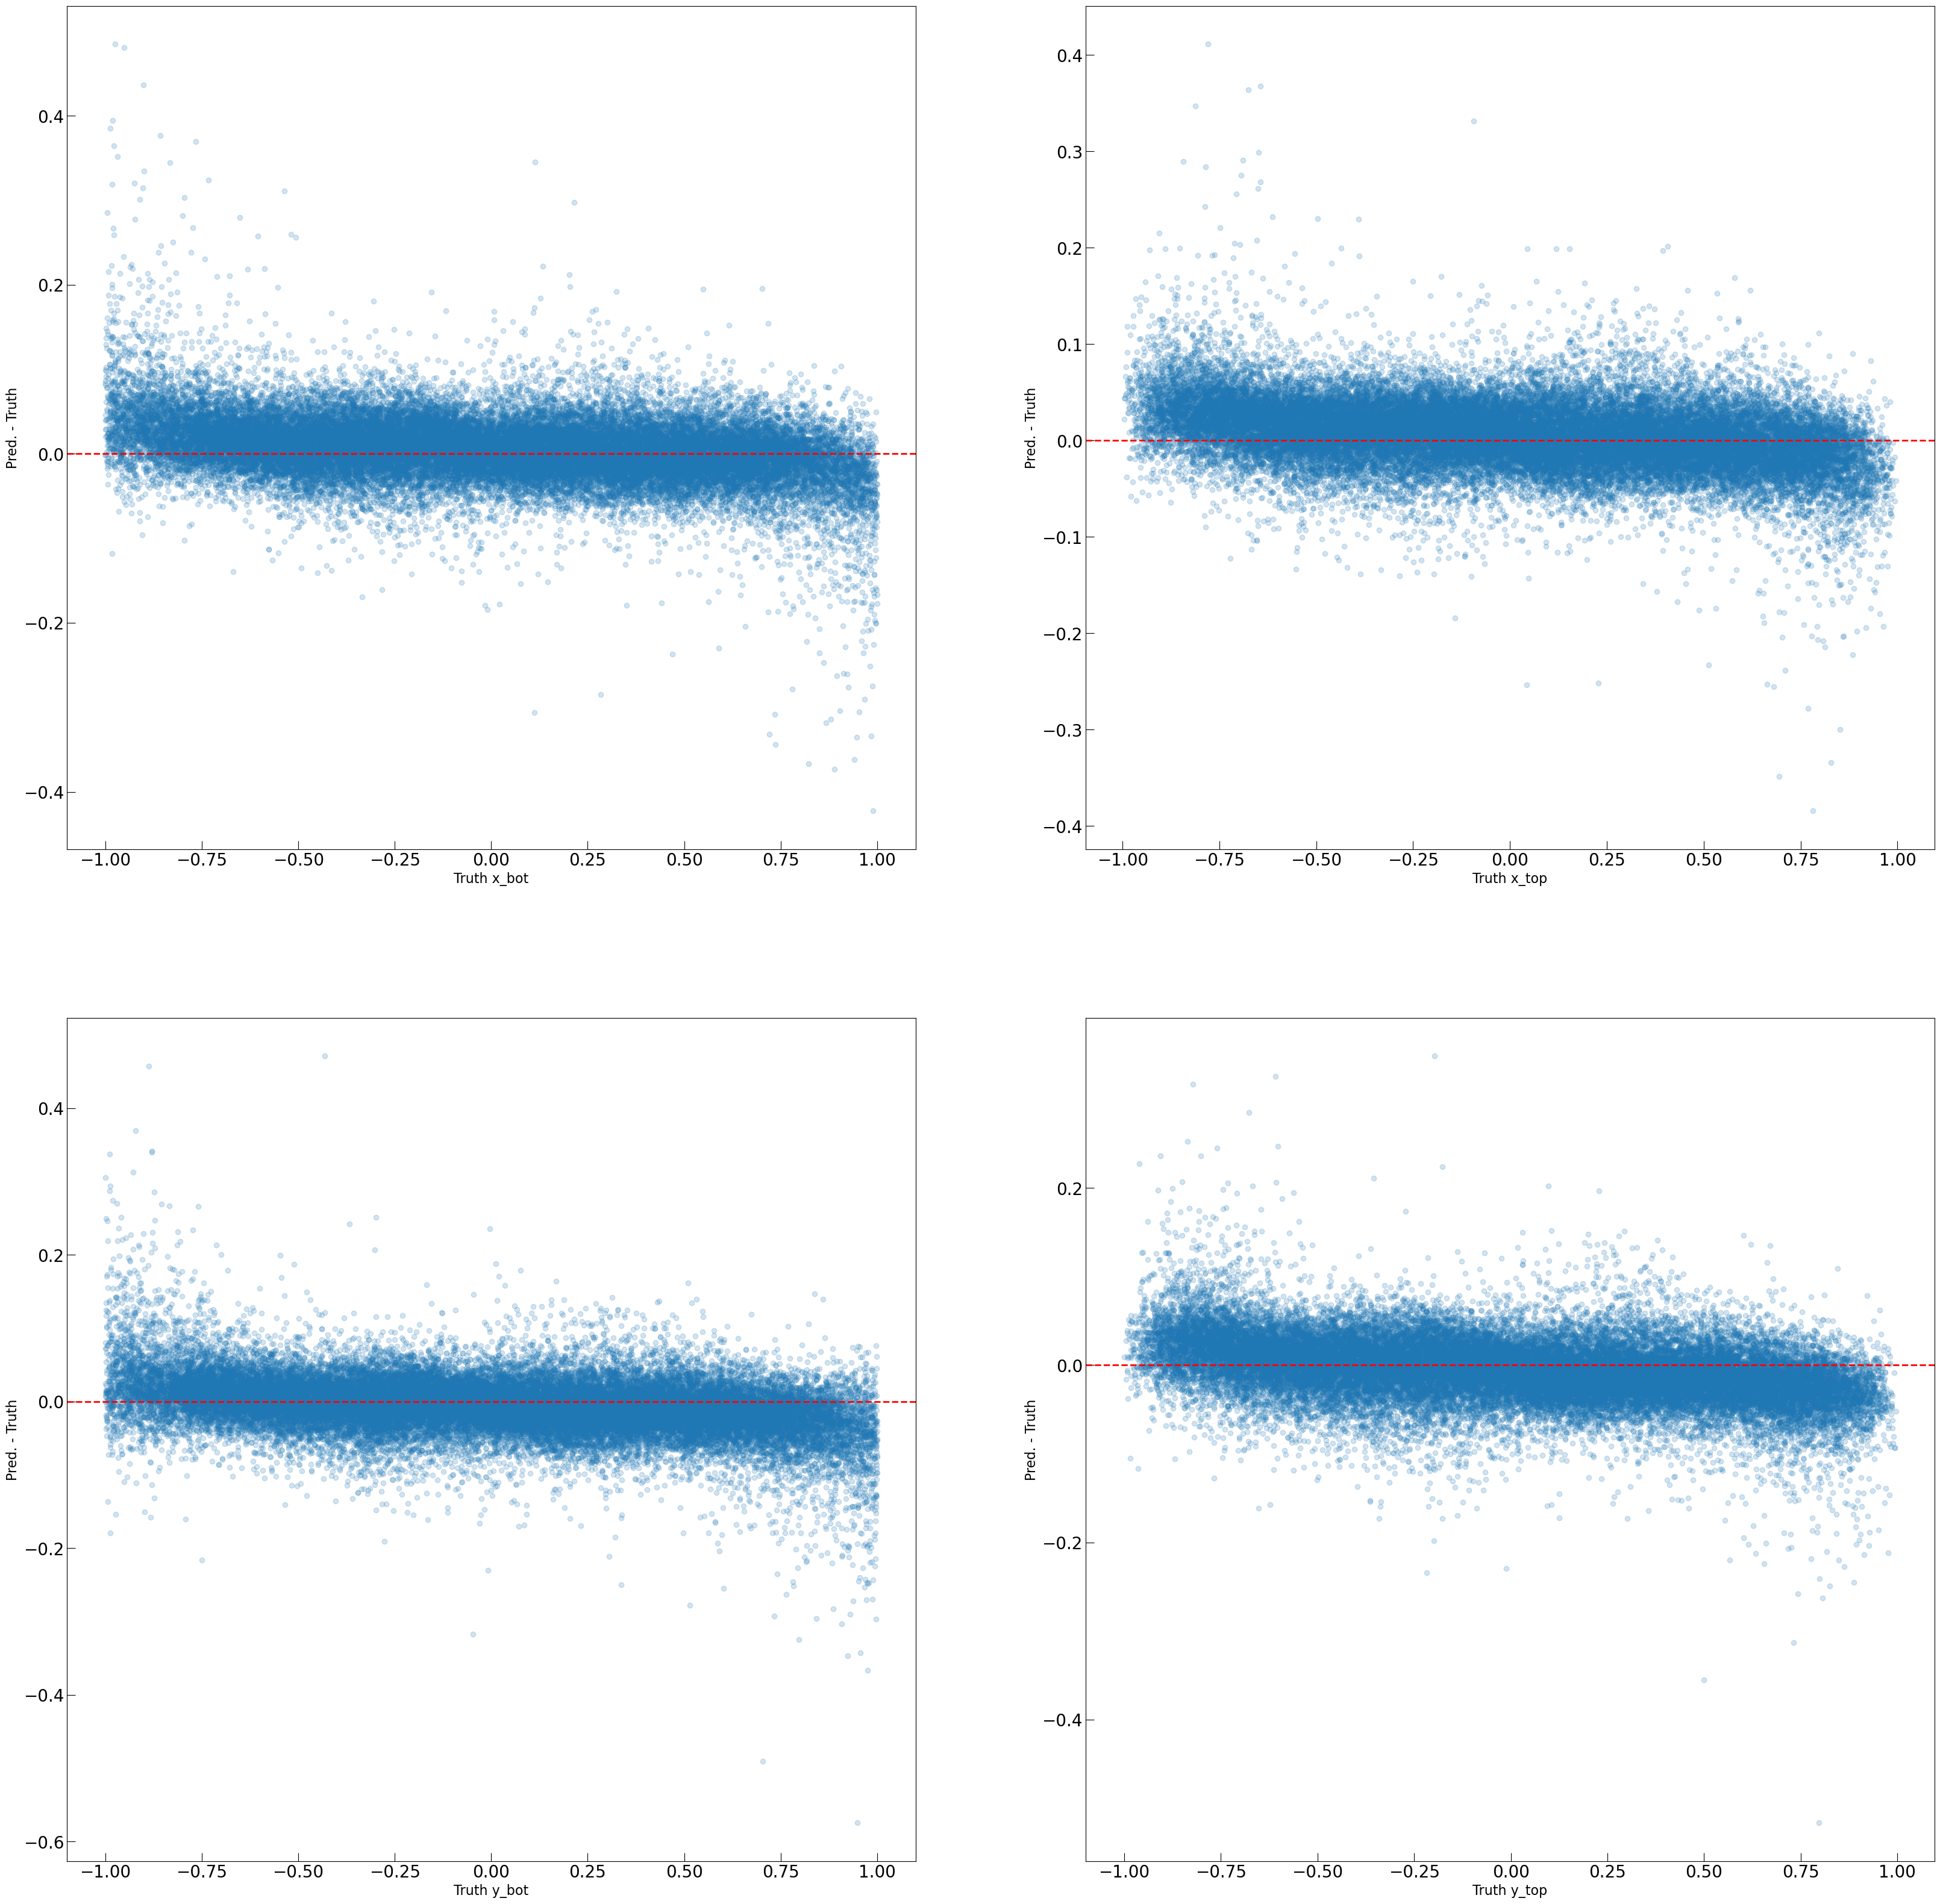

In [33]:
fig = plotting.plot_bias_truth(pred_coords, test_coords, var_label=labels)

plt.show()
fig.clf()

### Plot the co-ordinates as a 2D histogram

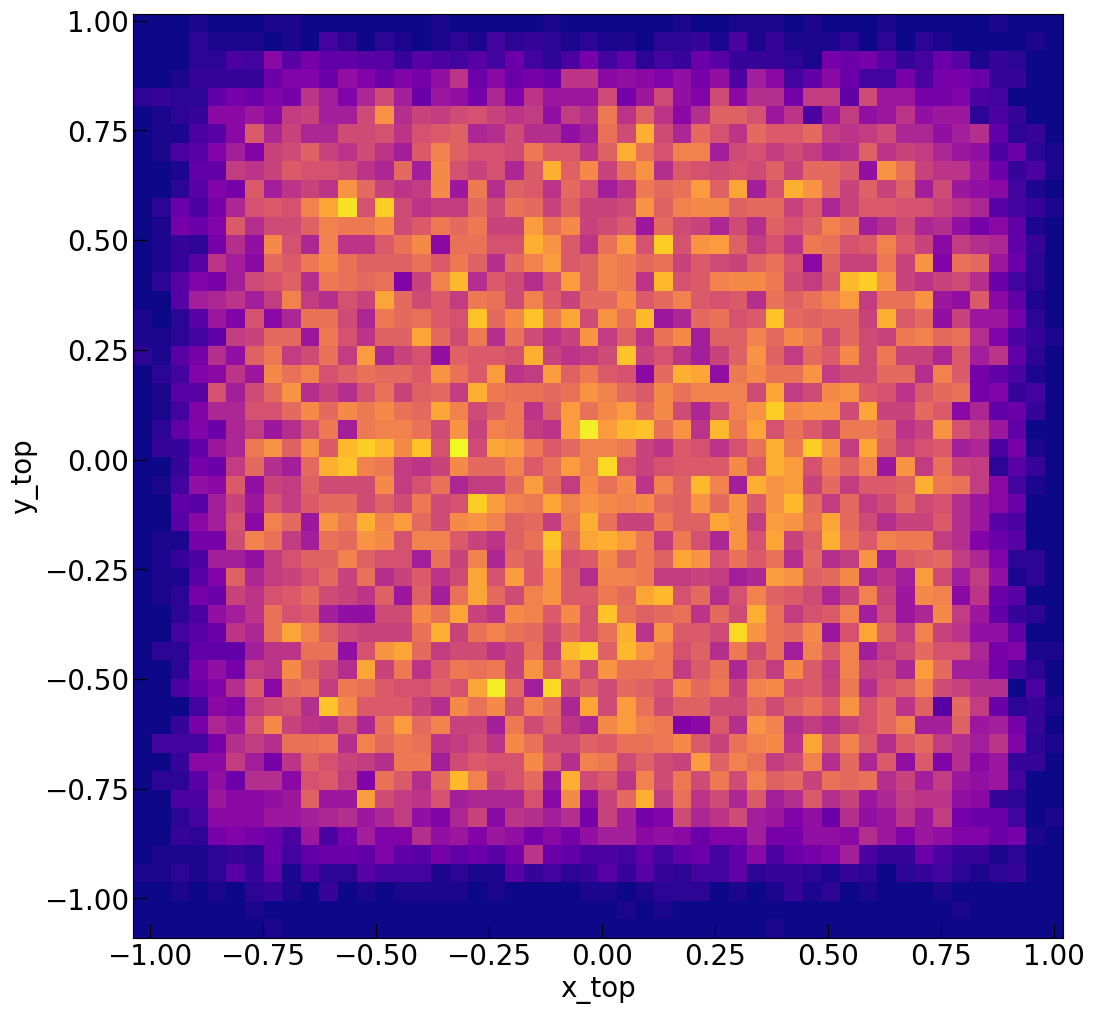

In [34]:
fig, ax = plt.subplots(figsize=(12,12))

h = ax.hist2d(pred_coords[:, 1], pred_coords[:, 3], 
              bins=50, cmap='plasma', 
              density=True, 
              cmin=0.0, cmax=1.0)
ax.set_xlabel('x_top')
ax.set_ylabel('y_top')
# fig.colorbar(h[3], ax=ax)
# fig.savefig("cnn_2022_05_26_dropout_max_deposit_maxEbar_energies_pred_top_coords.pdf")
plt.show()

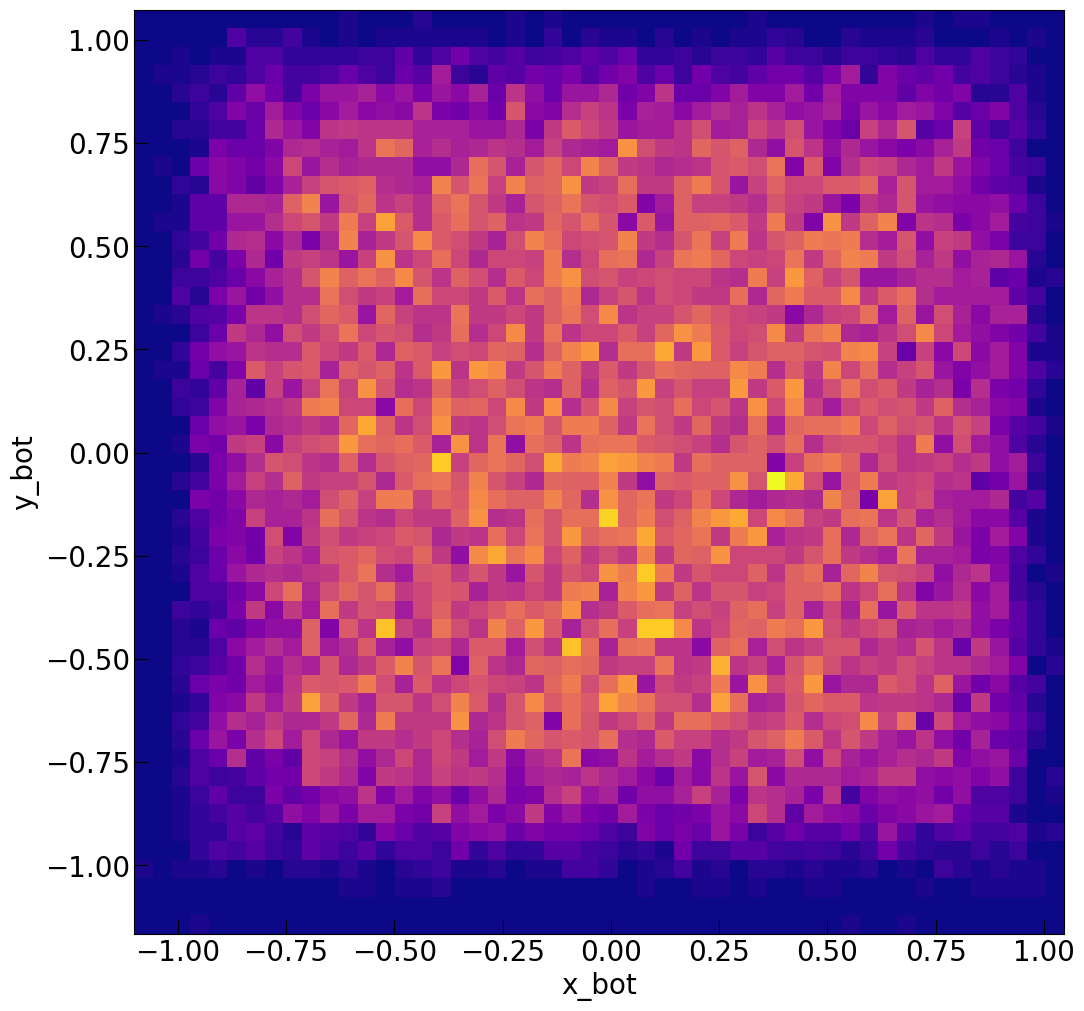

In [35]:
fig, ax = plt.subplots(figsize=(12,12))

h = ax.hist2d(pred_coords[:, 0], pred_coords[:, 2], 
              bins=50, cmap='plasma', 
              density=True,
              cmin=0.0, cmax=1.0)
ax.set_xlabel('x_bot')
ax.set_ylabel('y_bot')
# fig.colorbar(h[3], ax=ax)
# fig.savefig("cnn_2022_05_26_dropout_max_deposit_maxEbar_energies_pred_bot_coords.pdf")
plt.show()

## Save model

In [28]:
import os
os.makedirs("model", exist_ok=True)
model.save("model/dampe_cnn_final.keras")